<a href="https://colab.research.google.com/github/JugglingNumbers/intraday_nope_research/blob/data_clean/%5Cnotebooks%5CNOPE_insample_regression.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [25]:
### created by @JugglingNumbers JugglingNumbers1@gmail.com

### **Functions**

In [26]:
import matplotlib.pyplot as plt
import statsmodels.tsa.stattools as ts
import statsmodels.api as sm

def calcLogit(filtered_df, x_col, y_cols, ret_col, volScale = False):
  print("\n\n\n\n")
  print("####################################################################")
  print("#############", y_cols, "###########################################")
  mod =sm.Logit(filtered_df[x_col], filtered_df.loc[:,y_cols])
  res = mod.fit()

  print(res.summary())

  preds = mod.predict(res.params, filtered_df.loc[:,y_cols])
  preds -= 0.5

  scaled_preds = preds

  fig, ax = plt.subplots()

  if volScale:
    scaled_preds = 0.17 * scaled_preds / filtered_df[ret_col].rolling(12).std().shift(1)
  scaled_preds = scaled_preds / abs(scaled_preds).mean()

  filtered_df['scaled_preds'] = scaled_preds
  filtered_df['scaled_preds'].plot(title='allocation level for scaled preditions', ylabel='leverage',ax=ax)

  plt.show(block=False)
  plt.close(fig)

  fig, ax = plt.subplots()

  filtered_df['strat_rets'] = filtered_df[ret_col] * filtered_df['scaled_preds'] / 24

  filtered_df['long_strat_rets'] = np.where(filtered_df['scaled_preds'] > 0, filtered_df['strat_rets'], 0)
  filtered_df['short_strat_rets'] = np.where(filtered_df['scaled_preds'] < 0, filtered_df['strat_rets'], 0)

  (filtered_df['strat_rets'] + 1).cumprod().plot(title='compound returns', ylabel='return', legend=True, ax=ax)
  (filtered_df[ret_col] / 24 + 1).cumprod().plot(title='compound returns', legend=True, ax=ax)

  (filtered_df['long_strat_rets'] + 1).cumprod().plot(title='compound returns', legend=True, ax=ax)
  (filtered_df['short_strat_rets'] + 1).cumprod().plot(title='compound returns', legend=True, ax=ax)

  print(f"success rate on longs: {(np.where(filtered_df['long_strat_rets'] > 0,True,False).sum() / np.where(filtered_df['long_strat_rets'] != 0, True, False).sum())}")
  print(f"success rate on shorts: {np.where(filtered_df['short_strat_rets'] > 0,True,False).sum() / np.where(filtered_df['short_strat_rets'] != 0, True, False).sum()}")

  plt.show(block=False)
  plt.close(fig)


### **Load the data**

In [27]:
import pandas as pd
import numpy as np

In [28]:
!git clone https://github.com/The-NOPE-Project/intraday_nope_research
%cd intraday_nope_research/scripts
DATA_PATH = "/content/intraday_nope_research/processed_data/"
all_data = pd.read_csv(DATA_PATH + 'allDataCombined.csv').loc[:,['timestamp', 'C', 'P', 'netDelta', 'stockVolumeAll', 'stockVolumeBus',
                                                                  'numStockTransactions', 'NOPE_busVolume', 'NOPE_allVolume', 'spyPrice']]

Cloning into 'intraday_nope_research'...
remote: Enumerating objects: 151, done.
remote: Counting objects: 100% (151/151), done.
remote: Compressing objects: 100% (117/117), done.
remote: Total 151 (delta 63), reused 114 (delta 31), pack-reused 0
Receiving objects: 100% (151/151), 6.19 MiB | 1.23 MiB/s, done.
Resolving deltas: 100% (63/63), done.
/content/intraday_nope_research/scripts/intraday_nope_research/scripts


### **Get data ready**

In [29]:
df1 = all_data.copy()
df1['timestamp'] = pd.Index(pd.to_datetime(df1['timestamp'])).tz_localize('US/Eastern')

df1 = df1.set_index('timestamp')
df1.index = pd.to_datetime(df1.index)
df1['time'] = df1.index.strftime("%H:%M:%S")

# Black friday was a short trading day but data was recorded with same SPY price from 13:10 - 16:00
df1 = df1.loc[:'2020-11-27 13:00:00-05:00',['NOPE_busVolume','spyPrice','time']]
df1['date'] = df1.index.strftime("%Y-%m-%d")
df1.columns = ['nope','spy','time','date']
df1['nope'] *= 100

### **Mean Reverting Series?**

Nope is clearly a mean reverting series - by construction

In [30]:
result = ts.adfuller(df1['nope'].dropna().values)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
	print('\t%s: %.3f' % (key, value))

ADF Statistic: -15.109341
p-value: 0.000000
Critical Values:
	1%: -3.431
	5%: -2.862
	10%: -2.567


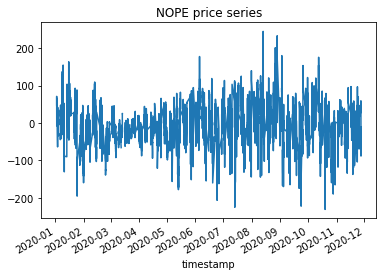

In [31]:
df1['nope'].plot(title='NOPE price series')

SPY is not

In [32]:
result = ts.adfuller(df1['spy'].values)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
	print('\t%s: %.3f' % (key, value))

ADF Statistic: -0.816673
p-value: 0.814175
Critical Values:
	1%: -3.431
	5%: -2.862
	10%: -2.567


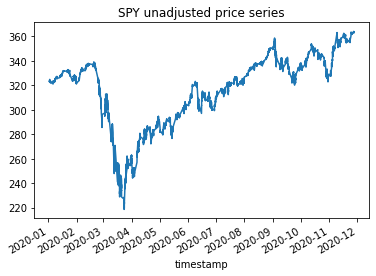

In [33]:
df1['spy'].plot(title='SPY unadjusted price series')

If we forward adjust SPY for overnight returns then it is...

In [34]:
df1['on_adjust'] = np.where(df1['date'].shift(1) != df1['date'], df1['spy'] / df1['spy'].shift(1) - 1, 0)
df1['spyAdjust'] = (df1['spy'] / (df1['on_adjust'].cumsum() + 1))

In [35]:
result = ts.adfuller(df1['spyAdjust'].dropna().values)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
	print('\t%s: %.3f' % (key, value))


ADF Statistic: -4.790967
p-value: 0.000057
Critical Values:
	1%: -3.431
	5%: -2.862
	10%: -2.567


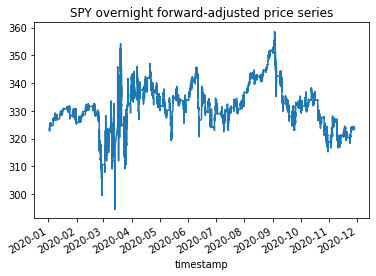

In [36]:
df1['spyAdjust'].plot(title='SPY overnight forward-adjusted price series')

### **More data prep**

Get data ready to run regression without one days data crossing over to the next

In [63]:
filtered_df = df1.loc[:,['nope','spy','time']].copy()
wlen = 24

# Using 24 * 5 minutes = 2 hours returns because its a round number and near the mean holding time of all trades in 
# https://github.com/JugglingNumbers/intraday_nope_research/blob/data_clean/NOPE_results_reproduction.ipynb

filtered_df['spy'] = filtered_df['spy'].pct_change(wlen)
filtered_df['spy_sign'] = np.where(filtered_df['spy']>0,1,0)

# We have to either shift our explanatory variables for or our
# dependant variables backward by the duration of the return we are examining
# to avoid lookback bias. we'll shift explanatory forward
# NOTE: once a variable has been shifted forward variables based on it
# are safe as long as they don't reach backwards and AREN'T used as dependant variables

filtered_df['nope'] = (filtered_df['nope'].shift(wlen))
filtered_df['dnope'] = filtered_df['nope'].diff()
filtered_df['spy24'] = filtered_df['spy'].shift(wlen)
filtered_df['dspy24'] = filtered_df['spy24'].diff()

# NaNs make statsmodels choke
filtered_df = filtered_df.dropna()

# since we calculated 2 hour returns any data points until 2 hours into the day
# would be using yesterdays results so we exclude them
filtered_df = filtered_df.loc[filtered_df['time'] > "11:30:00"]

In [64]:
filtered_df.describe()

,nope,spy,spy_sign,dnope,spy24,dspy24
count,13034.000000,13034.000000,13034.000000,13034.000000,13034.000000,1.303400e+04
mean,-8.459002,-0.000024,0.551020,-0.055888,0.000456,9.916058e-07
std,50.414457,0.006909,0.497409,13.725915,0.011157,3.685384e-03
min,-206.570918,-0.046074,0.000000,-182.831943,-0.084040,-6.848865e-02
25%,-34.575555,-0.002320,0.000000,-5.310293,-0.002859,-9.325203e-04
50%,-6.487593,0.000443,1.000000,0.178226,0.000659,-2.830753e-05
75%,19.429817,0.002774,1.000000,5.552587,0.004124,9.135572e-04
max,244.792161,0.059364,1.000000,155.202674,0.084451,9.936933e-02


### **OLS Regressions**

Nope is completely useless at predicting 2 hour forward returns???

In [65]:
mod = sm.OLS(filtered_df['spy'], filtered_df.loc[:,['nope']])

res = mod.fit()

print(res.summary())

                                 OLS Regression Results                                
Dep. Variable:                    spy   R-squared (uncentered):                   0.000
Model:                            OLS   Adj. R-squared (uncentered):             -0.000
Method:                 Least Squares   F-statistic:                             0.8222
Date:                Wed, 10 Feb 2021   Prob (F-statistic):                       0.365
Time:                        04:12:33   Log-Likelihood:                          46349.
No. Observations:               13034   AIC:                                 -9.270e+04
Df Residuals:                   13033   BIC:                                 -9.269e+04
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------

Same with dnope...

In [66]:
mod = sm.OLS(filtered_df['spy'], filtered_df.loc[:,['dnope']])

res = mod.fit()

print(res.summary())

                                 OLS Regression Results                                
Dep. Variable:                    spy   R-squared (uncentered):                   0.000
Model:                            OLS   Adj. R-squared (uncentered):              0.000
Method:                 Least Squares   F-statistic:                              2.212
Date:                Wed, 10 Feb 2021   Prob (F-statistic):                       0.137
Time:                        04:12:34   Log-Likelihood:                          46350.
No. Observations:               13034   AIC:                                 -9.270e+04
Df Residuals:                   13033   BIC:                                 -9.269e+04
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------

lol good old momentum

In [67]:
mod = sm.OLS(filtered_df['spy'].values, filtered_df['spy24'].values)

res = mod.fit()

print(res.summary())

                                 OLS Regression Results                                
Dep. Variable:                      y   R-squared (uncentered):                   0.000
Model:                            OLS   Adj. R-squared (uncentered):              0.000
Method:                 Least Squares   F-statistic:                              3.865
Date:                Wed, 10 Feb 2021   Prob (F-statistic):                      0.0493
Time:                        04:12:34   Log-Likelihood:                          46351.
No. Observations:               13034   AIC:                                 -9.270e+04
Df Residuals:                   13033   BIC:                                 -9.269e+04
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------

### Logit **Regressions**

The fact that Nope has such a high win rate, but such high volatility of returns (as highlighted here https://twitter.com/jugglingnumbers/status/1358613100019261440) and low mean returns might suggest its useful in predicting the sign of returns but not their magnitude? Lets try Logit regression on a binary sign variable.

Quick Note: I've included compound return charts to provide some context as to whether statistical significance might be economically significant and because - lets be honest - it drives engagement. These are in-sample with no techniques used to mitigate overfitting, they are highly unlikely to be robust out of sample. 

Also, I've applied a simple scaling to get average allocation to be 1 across all periods. This means allocations can be -20 to 20x leveraged at times - totally unrealistic but ensures you can see the signal and not the effects of differential scaling.






####################################################################
############# ['nope'] ###########################################
Optimization terminated successfully.
         Current function value: 0.692672
         Iterations 3
                           Logit Regression Results                           
Dep. Variable:               spy_sign   No. Observations:                13034
Model:                          Logit   Df Residuals:                    13033
Method:                           MLE   Df Model:                            0
Date:                Wed, 10 Feb 2021   Pseudo R-squ.:               -0.006891
Time:                        04:12:35   Log-Likelihood:                -9028.3
converged:                       True   LL-Null:                       -8966.5
Covariance Type:            nonrobust   LLR p-value:                       nan
                 coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------

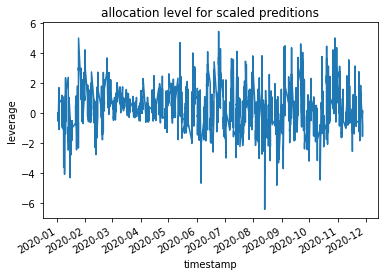

success rate on longs: 0.5658411151712004
success rate on shorts: 0.4662041977943792


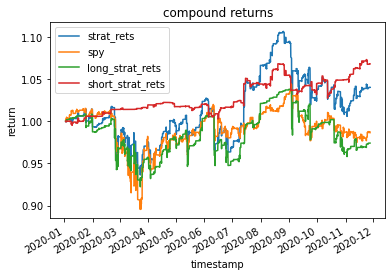

In [68]:
calcLogit(filtered_df, x_col = 'spy_sign', y_cols=['nope'], ret_col = 'spy', volScale=False)

So exactly as we would expect, nope predicts 2 hour SPY returns sign inversely (negative nope predicts positive SPY returns) but doesn't explain alot (consistent with aweful return to risk results seen in https://github.com/JugglingNumbers/intraday_nope_research/blob/data_clean/NOPE_results_reproduction.ipynb)






####################################################################
############# ['spy24'] ###########################################
Optimization terminated successfully.
         Current function value: 0.692111
         Iterations 4
                           Logit Regression Results                           
Dep. Variable:               spy_sign   No. Observations:                13034
Model:                          Logit   Df Residuals:                    13033
Method:                           MLE   Df Model:                            0
Date:                Wed, 10 Feb 2021   Pseudo R-squ.:               -0.006075
Time:                        04:12:36   Log-Likelihood:                -9021.0
converged:                       True   LL-Null:                       -8966.5
Covariance Type:            nonrobust   LLR p-value:                       nan
                 coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------

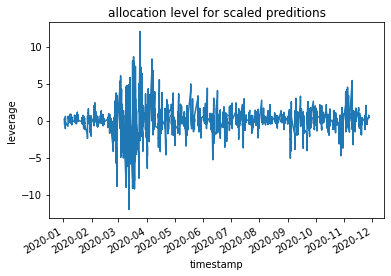

success rate on longs: 0.5568600682593857
success rate on shorts: 0.4550750220653133


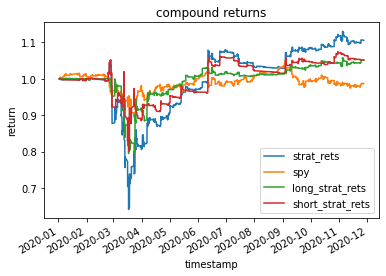

In [69]:
calcLogit(filtered_df, x_col = 'spy_sign', y_cols=['spy24'], ret_col = 'spy', volScale=False)

Prior 2 hour returns predict the sign of forward 2 hour returns positively (momentum)






####################################################################
############# ['dnope'] ###########################################
Optimization terminated successfully.
         Current function value: 0.692846
         Iterations 3
                           Logit Regression Results                           
Dep. Variable:               spy_sign   No. Observations:                13034
Model:                          Logit   Df Residuals:                    13033
Method:                           MLE   Df Model:                            0
Date:                Wed, 10 Feb 2021   Pseudo R-squ.:               -0.007143
Time:                        04:12:37   Log-Likelihood:                -9030.6
converged:                       True   LL-Null:                       -8966.5
Covariance Type:            nonrobust   LLR p-value:                       nan
                 coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------

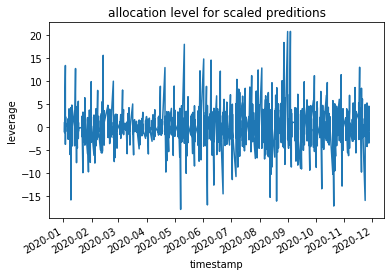

success rate on longs: 0.5611668757841907
success rate on shorts: 0.4568198944988696


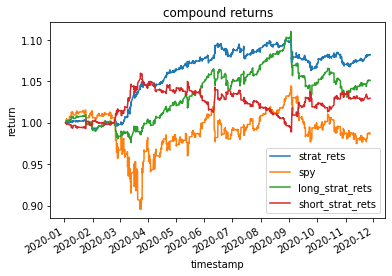

In [70]:
calcLogit(filtered_df, x_col = 'spy_sign', y_cols=['dnope'], ret_col = 'spy', volScale=False)

changes in nope are also inversely predictive






####################################################################
############# ['dspy24'] ###########################################
Optimization terminated successfully.
         Current function value: 0.692971
         Iterations 4
                           Logit Regression Results                           
Dep. Variable:               spy_sign   No. Observations:                13034
Model:                          Logit   Df Residuals:                    13033
Method:                           MLE   Df Model:                            0
Date:                Wed, 10 Feb 2021   Pseudo R-squ.:               -0.007325
Time:                        04:12:38   Log-Likelihood:                -9032.2
converged:                       True   LL-Null:                       -8966.5
Covariance Type:            nonrobust   LLR p-value:                       nan
                 coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------

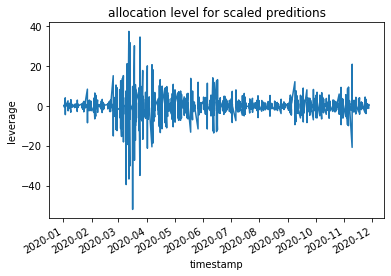

success rate on longs: 0.5615256546087483
success rate on shorts: 0.45789720356194347


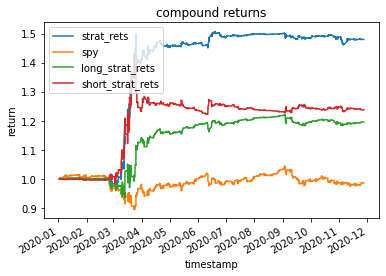

In [71]:
calcLogit(filtered_df, x_col = 'spy_sign', y_cols=['dspy24'], ret_col = 'spy', volScale=False)

Changes in 2 hour returns are less significantly inversely predictive






####################################################################
############# ['nope', 'spy24'] ###########################################
Optimization terminated successfully.
         Current function value: 0.690661
         Iterations 4
                           Logit Regression Results                           
Dep. Variable:               spy_sign   No. Observations:                13034
Model:                          Logit   Df Residuals:                    13032
Method:                           MLE   Df Model:                            1
Date:                Wed, 10 Feb 2021   Pseudo R-squ.:               -0.003968
Time:                        04:12:39   Log-Likelihood:                -9002.1
converged:                       True   LL-Null:                       -8966.5
Covariance Type:            nonrobust   LLR p-value:                     1.000
                 coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------

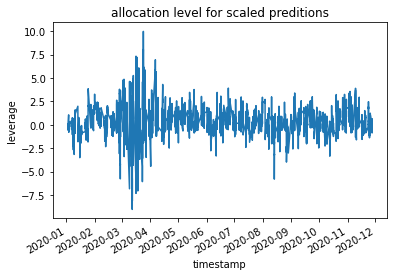

success rate on longs: 0.5781784680178994
success rate on shorts: 0.48475891372621466


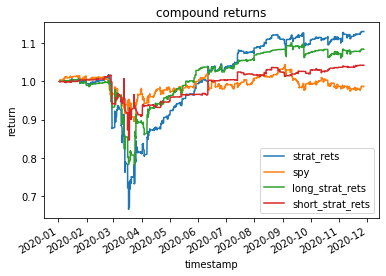

In [72]:
calcLogit(filtered_df, x_col = 'spy_sign', y_cols=['nope','spy24'], ret_col = 'spy', volScale=False)

So returns and nope make each more statistically significant. Past returns and derivations of such are ubitquitous in predicting returns. The fact that nope doesn't seem to be getting its signal from that source is good! Strong support for the idea that nope could be useful in ensembles.






####################################################################
############# ['nope', 'spy24', 'dnope'] ###########################################
Optimization terminated successfully.
         Current function value: 0.690464
         Iterations 4
                           Logit Regression Results                           
Dep. Variable:               spy_sign   No. Observations:                13034
Model:                          Logit   Df Residuals:                    13031
Method:                           MLE   Df Model:                            2
Date:                Wed, 10 Feb 2021   Pseudo R-squ.:               -0.003681
Time:                        04:12:40   Log-Likelihood:                -8999.5
converged:                       True   LL-Null:                       -8966.5
Covariance Type:            nonrobust   LLR p-value:                     1.000
                 coef    std err          z      P>|z|      [0.025      0.975]
----------------------------

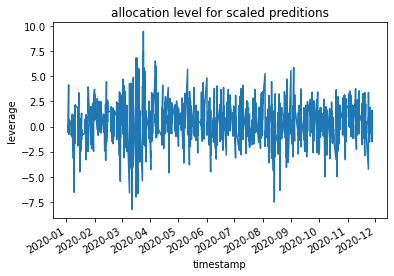

success rate on longs: 0.5773429179978701
success rate on shorts: 0.48263320603746135


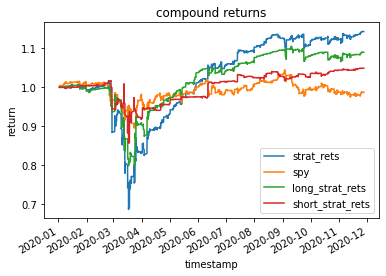

In [73]:
calcLogit(filtered_df, x_col = 'spy_sign', y_cols=['nope','spy24','dnope'], ret_col = 'spy', volScale=False)

dnope washes out a bit when added, but no effect on returns and nope






####################################################################
############# ['nope', 'spy24', 'dnope', 'dspy24'] ###########################################
Optimization terminated successfully.
         Current function value: 0.690203
         Iterations 5
                           Logit Regression Results                           
Dep. Variable:               spy_sign   No. Observations:                13034
Model:                          Logit   Df Residuals:                    13030
Method:                           MLE   Df Model:                            3
Date:                Wed, 10 Feb 2021   Pseudo R-squ.:               -0.003302
Time:                        04:12:41   Log-Likelihood:                -8996.1
converged:                       True   LL-Null:                       -8966.5
Covariance Type:            nonrobust   LLR p-value:                     1.000
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------

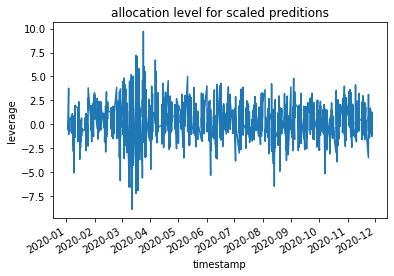

success rate on longs: 0.5794043007880326
success rate on shorts: 0.4851556842867487


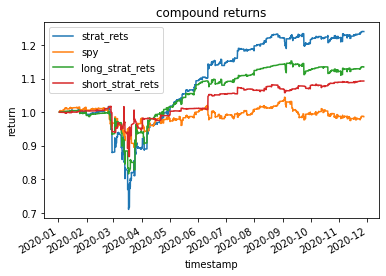

In [74]:
calcLogit(filtered_df, x_col = 'spy_sign', y_cols=['nope','spy24','dnope','dspy24'], ret_col = 'spy', volScale=False)

Not surprisingly the change in returns kills the usefulness of dnope. Since nope and spy are highly correlated it's not entirely surprising that their rates of change are redundant.

### **Position sizing in the form of Volatility Targetting is good!**






####################################################################
############# ['nope', 'spy24', 'dnope', 'dspy24'] ###########################################
Optimization terminated successfully.
         Current function value: 0.690203
         Iterations 5
                           Logit Regression Results                           
Dep. Variable:               spy_sign   No. Observations:                13034
Model:                          Logit   Df Residuals:                    13030
Method:                           MLE   Df Model:                            3
Date:                Wed, 10 Feb 2021   Pseudo R-squ.:               -0.003302
Time:                        04:12:42   Log-Likelihood:                -8996.1
converged:                       True   LL-Null:                       -8966.5
Covariance Type:            nonrobust   LLR p-value:                     1.000
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------

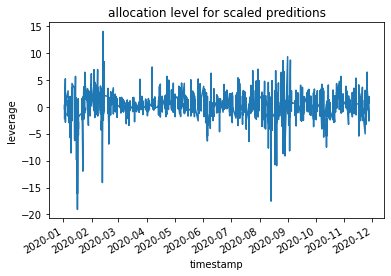

success rate on longs: 0.5793481164841037
success rate on shorts: 0.4859423181570833


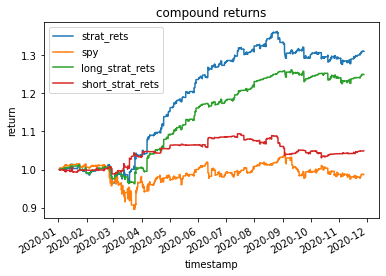

In [75]:
calcLogit(filtered_df, x_col = 'spy_sign', y_cols=['nope','spy24','dnope','dspy24'], ret_col = 'spy', volScale=True)

This is the exact same model as above but it adjusts position sizes by considering recent volatility. This simple implementation of volatility targetting rescales predictions by the past 1 hour of returns, before we rescale to average 1x leverage over the whole period. This naturally reduces exposure when volatility is high and increases it when it is low. Notice the minimal draw down in March and April? Look at how low leverage was durring March and April.

### **Caveats and potential avenues of interest**

1) This was primarily intended to explore the relationship between nope and forward returns in the area that nope has some trading potential. Nothing here should be viewed as a realistic investment approach.

2) I'll have alot more confidence in nope being real if these results are reproduced out of sample (the regression significance) and there is stability in coefficient estimates.

3) brutal drawdown for the non-vol targetting ensemble does suggest the possibility that intraday nope works primarily during strong rallies - even though the returns are realized during the day when markets have been mostly flat. This could also be due to nope being a spurious correlation with this particular 6 months.

4) Are there any examples of intraday momentum strategies that worked during this period?

5) How long have intraday returns been a mean reverting series? Since the total return has been realized overnight? or were they trending for part of this time?

6) Does the mean reverting property intraday hold at frequencies other than 5 minutes?